In [1]:
# Hyperparameters And Configs

max_df = 0.9  # [0.9, 0.95]
ngram_range = (1,2) # [(1,1), (1,2)]
min_samples_leaf = 2 # [1,2]
max_depth = 2000 # [50, 70]
random_seed = 42
test_size = 0.1

data_dir = '../linguistic-pipeline-tests/data/train.csv'
feat_out_train = './test_outputs/feats_train.npz'
feat_out_test = './test_outputs/feats_test.npz'

In [2]:
#creating a function to encapsulate preprocessing, to mkae it easy to replicate on  submission data
def processing(df):
    
    #stopwords are filler words with little semantic content
    stopWords = set(stopwords.words('english'))
    
    
    #lowering and removing punctuation
    df['processed'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]','', x.lower()))
    
    #numerical feature engineering
    #total length of sentence
    df['length'] = df['processed'].apply(lambda x: len(x))
    #get number of words
    df['words'] = df['processed'].apply(lambda x: len(x.split(' ')))
    df['words_not_stopword'] = df['processed'].apply(lambda x: len([t for t in x.split(' ') if t not in stopWords]))
    #get the average word length
    df['avg_word_length'] = df['processed'].apply(lambda x: np.mean([len(t) for t in x.split(' ') if t not in stopWords]) if len([len(t) for t in x.split(' ') if t not in stopWords]) > 0 else 0)
    #get the average word length
    df['commas'] = df['text'].apply(lambda x: x.count(','))

    return(df)



def get_train_test_split(data_dir):
    
    df = pd.read_csv(data_dir)
    df.dropna(axis=0)
    df.set_index('id', inplace = True) 
#     stopWords = set(stopwords.words('english'))
    df = processing(df)
    features= [c for c in df.columns.values if c  not in ['id','text','author']]
    numeric_features= [c for c in df.columns.values if c  not in ['id','text','author','processed']]
    target = 'author'
    X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=test_size, random_state=42)
    
    return X_train, X_test, y_train, y_test


In [3]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import re
import scipy.sparse

from nltk.corpus import stopwords
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import os
 
X_train, X_test, _, _= get_train_test_split(data_dir)

 
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

feature_extractor = Pipeline([
                ('selector', TextSelector(key='processed')),
                ('tfidf', TfidfVectorizer( stop_words='english', max_df=max_df, ngram_range=ngram_range ))
            ])

feature_extractor.fit(X_train)

X_feats_train = feature_extractor.transform(X_train)
X_feats_test = feature_extractor.transform(X_test)


print("(0) ==>", type(X_feats_train), type(X_feats_test))
print("(1) ==>", X_feats_train.shape, X_feats_test.shape,) 

scipy.sparse.save_npz(feat_out_train, X_feats_train)
scipy.sparse.save_npz(feat_out_test, X_feats_test)

(0) ==> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
(1) ==> (17621, 194331) (1958, 194331)


There's a lot of ways to save numpy arrays in disk

See: https://stackoverflow.com/questions/9619199/best-way-to-preserve-numpy-arrays-on-disk

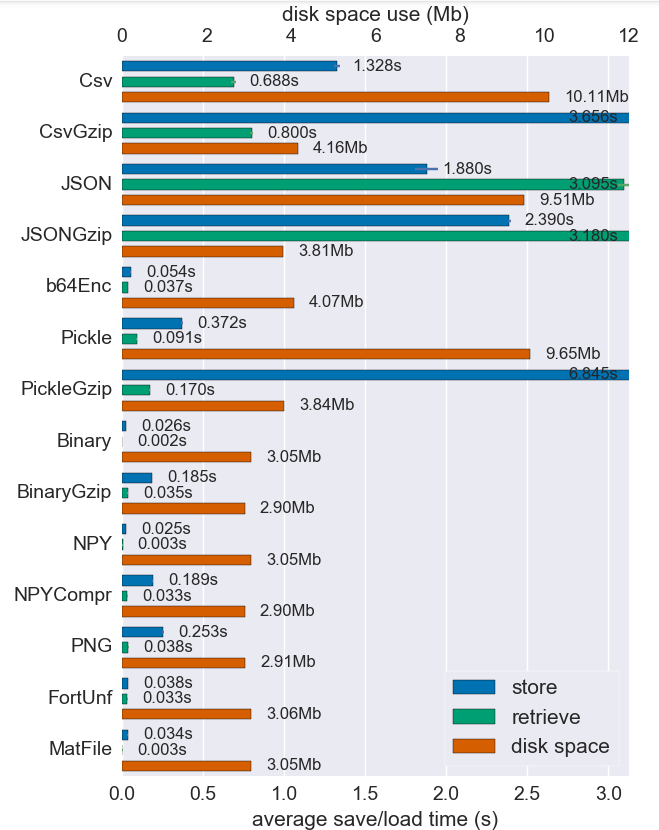

In [4]:
from sklearn.ensemble import RandomForestClassifier

_, _, y_train, y_test = get_train_test_split(data_dir)
    
X_feats_train = scipy.sparse.load_npz(feat_out_train)
X_feats_test = scipy.sparse.load_npz(feat_out_test)

print("(2) ==>", X_feats_train.shape, X_feats_test.shape) 

classifier = Pipeline([ 
    ('classifier', RandomForestClassifier(min_samples_leaf=min_samples_leaf, max_depth=max_depth, random_state=random_seed)),
])

classifier.fit(X_feats_train, y_train)
preds = classifier.predict(X_feats_test)
np.mean(preds == y_test)

(2) ==> (1958, 194331) (1958, 194331)


ValueError: Found input variables with inconsistent numbers of samples: [1958, 17621]